# Learning Vector Quantization applied to text classification

Learning Vector Quantization (Kohonen 1986, cf. Kohonen 1998) is a supervised classification approach. 
LVQ is a prototype-based competitive learning network that learns prototypes
by moving 'winning' prototypes into the direction of the respective data point (and moving 'loosing'
prototypes in the opposite direction). The prototypes are defined in the feature space of the input data,
which makes LVQ models more readily interpretable by domain experts than other neural network approaches.
Martín-Valdivia, Ureña-López and García-Vega (2007) applied LVQ to textual data in two different classification tasks,
namely text categorization and word sense disambiguation, and showed that it yielded superior performance in comparison
to other common algorithms such as Naive Bayes, SVMs and k-NN in their case.

Following this line of research, I will report on a experiment in text classfication using the LVQ implementation
provided by [Neurolab](https://github.com/zueve/neurolab) ([example](https://pythonhosted.org/neurolab/ex_newlvq.html)). While LVQ exists in various improved variants, 
Ńeurolab only implements the basic version as originally proposed by Kohonen (LVQ1). There is one major difference tough. Unlike the original learning algorithm, the Neurlab [implementation](https://github.com/zueve/neurolab/blob/master/neurolab/train/lvq.py) does not select training examples randomly. A (far from perfect) workaround is to shuffle the training data before training and do several runs.

## Dataset - DBMail newsletter

The [data set](https://archive.ics.uci.edu/ml/datasets/DBWorld+e-mails) used in the experiment is a collection of emails from the ACM SIGMOD [DBWorld newsletter](https://research.cs.wisc.edu/dbworld/). It was created by then Ph.D. student [Michele Filannino](http://www.michelefilannino.com/) in the context of a machine learning term [paper](https://archive.ics.uci.edu/ml/datasets/%3Ca%20href=%22http://www.cs.man.ac.uk/~filannim/dbworld_email_classification.pdf%22%3E[Web%20Link]%3C/a%3E) (Filannino 2011). The data set contains 64 emails in a bag of words representation, where every row is a vector with all entries set to 1 for all vocabulary words contained in the document (and all others zero). The vocabulary consists of all unique words in the corpus with a minimum length of 3 and a maximum length of 30 characters. The data set is seperated into subsets containing only bodies or subjects, each subset also being available in a [stemmed](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) version, which were produced using Porter's algorithm (Porter 1980). I only use the two subjects data sets in my experiment. The vocabulary has a size (or dimensionality) of 242 (229 stemmed), which makes it a very small data set with relatively high dimensionality. The class lables indicate wheter the email annouces a conference (29 samples, CLASS = 1) or not (35 samples, CLASS = 0).

## Imports

In [1]:
%matplotlib inline

import csv
from random import shuffle

import numpy as np
import neurolab as nl
from matplotlib import pylab as plt
from sklearn.manifold import TSNE

## Preprocessing

Before training, the data set has to be transformed into a suitable format. While the orignal data comes as a CSV file in which every row also has a CLASS column, it has to be turned into two seperated numpy arrays containing the data and the targets/labels respectively. Additionally, the encoding of the training label values has to match the LVQ structure: In my example I use two prototypes, so the output will also be two dimensional with the value set to one which corresponds to the respective label.

In [180]:
def encode_labels(labels, n_prototypes = 1):
    target = []
    for label in labels:
        if label == 0:
            label_encoding = np.concatenate([np.ones(n_prototypes), np.zeros(n_prototypes)])
            target.append(label_encoding)
        elif  label == 1:
            label_encoding = np.concatenate([np.zeros(n_prototypes), np.ones(n_prototypes)])
            target.append(label_encoding)
    return np.array(target)

def decode_labels(targets):
    labels = []
    n_prototypes = len(targets[0]) / 2
    pos_label = [1]
    neg_label = [0]
    encoded_label_neg = encode_labels(neg_label, n_prototypes)[0]
    encoded_label_pos = encode_labels(pos_label, n_prototypes)[0]
    for target in targets:
        if np.array_equal(target, encoded_label_neg):
            labels.append(0)
        elif np.array_equal(target, encoded_label_pos):
            labels.append(1)
    return labels

def load_data(path):
    data = []
    labels = []
    feature_names = []
    with open(path) as f:
        reader = csv.reader(f, delimiter=',',)
        header = reader.next()
        feature_names = header[:-1] # header without CLASS
        for row in reader:
            row_values = map(int, row) # parse string to int
            label = row_values.pop()
            labels.append(label)
            data.append(row_values)
    return (np.array(data), labels, feature_names)

In [181]:
original_data, labels, feature_names = load_data('dbworld_subjects_stemmed.csv')

In [182]:
original_target = encode_labels(labels, 1) 

To compensate the lack of randomisation in the Neurolab LVQ implementation, the data is  shuffled before training. I've experimented with two approaches. At first, I had a look at the CSV file which seemed to suggest to use the last 20 rows of the data set as test set. Shuffling then was done for train and test set seperately. Later, I also experimented with shuffling the data before splitting into tain and test set. While this can lead to diverging class distributions in the train and test data, I found it to sometimes give better evaluation measures than the standard split. This observation motivates cross-validation.

In [183]:
def shuffle_labeled_data(original_data, original_target, do_shuffle=True):
    shuffled = zip(original_data, original_target)
    if (do_shuffle):
        shuffle(shuffled)
    data = np.array([data for data, _ in shuffled])
    target = np.array([target for _, target in shuffled])
    return data, target

In [184]:
# shuffle the data before applying split into train and test? 
do_shuffle = False
original_data, original_target = shuffle_labeled_data(original_data, original_target, do_shuffle)

In [185]:
TRAIN_TEST_SPLIT = -14
original_train_data = original_data[:TRAIN_TEST_SPLIT]
original_train_target = original_target[:TRAIN_TEST_SPLIT]
original_test_data = original_data[TRAIN_TEST_SPLIT:]
original_test_target = original_target[TRAIN_TEST_SPLIT:]

In [186]:
train_data, train_target = shuffle_labeled_data(original_train_data, original_train_target)
test_data, test_target = shuffle_labeled_data(original_test_data, original_test_target)

In [187]:
train_N, num_dimensions = train_data.shape
test_N, _ = test_data.shape
print 'train (N,d): ', train_N, num_dimensions
print 'test (N,d): ', test_N, num_dimensions


train (N,d):  50 229
test (N,d):  14 229


## Setting up LVQ and Training

The LVQ network has two layers: An input layer which has as many neurons as the data has dimensions and an output layer with as many neurons as there are classes. Each output neuron is connected to all the inputs and the learned weights represent the prototypes or codebook vectors. The two main parameters for training is the number of epochs (how many iterations over the training data) and the learning rate (a factor determining how strongly each update influences the prototype values).

In [188]:
net = nl.net.newlvq(nl.tool.minmax(train_data), num_dimensions, [0.5, 0.5])
error = net.train(train_data, train_target, epochs=200, lr=0.0001, goal=-1)

Epoch: 100; Error: 0.5;
Epoch: 200; Error: 0.28;
The maximum number of train epochs is reached


## Evaluation

Using the standard test split, I managed to beat the majority baseline by about 7% accuracy most of the times, sometimes hitting it. My general observation is, that the number of epochs and the learning rate need to be balanced to get better accuracies. If one of the parameters is too high, the network will have low error rates on the training data, but will loose some of its capability to generalize. At the same time, if the learning rate and the number of epochs are too small, the network seems not to have the chance to actually adapt the prototypes in way that makes them capture some of the characteristics of the data.

In [189]:
output = net.sim(test_data)

In [190]:
def majority_baseline(test_target, neg_class):
    class_counts = [0,0]
    for labels in test_target:
        if np.array_equal(labels, neg_class):
            class_counts[0] += 1
        else:
            class_counts[1] += 1
    return np.max(class_counts) / float(len(test_target))

def evaluate(output, test_target):
    right = 0
    for i, labels in enumerate(output):
        if np.array_equal(labels, test_target[i]):
            right += 1
    return right / float(len(test_target))

In [191]:
n_prototypes = len(original_test_target[0]) / 2
neg_label = encode_labels([0], n_prototypes)[0]
print 'Majority baseline: ', majority_baseline(test_target, neg_label)
print 'Accuracy: ', evaluate(output, test_target)

Majority baseline:  0.714285714286
Accuracy:  0.785714285714


## Visualizing the prototypes

To get a better idea of the learned prototypes, I wanted to analyze them a litte further. First, I tried to visualise them in a two-dimensional projection together with the training and test data to see how they relate. To do this, I picked t-SNE after some reading on suitable methods for text visualisation. There is no clear separation in the projected data, but rather one big cluster. So it seems to make sense that the prototypes sit at the edges, each being closer to one part of the cluster. Looking at the values, we can see that they have the same values, but one is positive and the other negative.

In [192]:
def get_prototypes(net):
    return net.layers[1].np['w']

In [193]:
tsne = TSNE(n_components=2, random_state=0, init='pca')
train_embedding = tsne.fit_transform(original_train_data)
test_embedding = tsne.fit_transform(original_test_data)
embedded_protos = tsne.fit_transform(get_prototypes(net))

In [194]:
embedded_protos

array([[ -3.99198576e+02,   2.05835818e-13],
       [  3.99198576e+02,  -2.05835818e-13]])

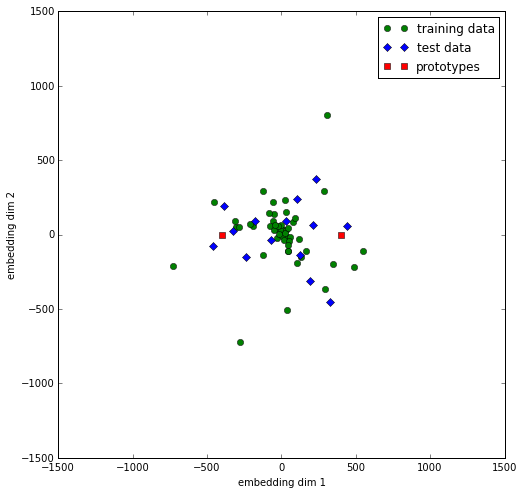

In [195]:
plt.figure(figsize=(8,8))
plt.plot(train_embedding[:,0], train_embedding[:,1], 'go')
plt.plot(test_embedding[:,0], test_embedding[:,1], 'bD')
plt.plot(embedded_protos[:,0], embedded_protos[:,1], 'rs')
plt.xlim(-1500,1500)
plt.ylim(-1500,1500)
plt.xlabel('embedding dim 1')
plt.ylabel('embedding dim 2')
plt.legend(['training data', 'test data', 'prototypes'])
plt.show()

Second, I mapped the prototype vectors back to the (stemmed) bag of words that they represent, including the label that the network would associate with each of the bags. Looking at the words for each label some make immediate sense (e.g. 'cfp' and dates in the conference class and 'job' or 'microsoft' in the no conference class), while others are hard to interpret (e.g. 'chicago' according to the prototypes is a place for conferences while 'zurich' is not).

In [196]:
def get_prototype_words_and_labels(net, feature_names):
    # the prototypes are the weights of the second layer
    labeled_bags_of_words = []
    prototypes = net.layers[1].np['w']
    for prototype in prototypes:
        bag_of_words = []
        for index, entry in enumerate(prototype):
            if entry == 1:
                bag_of_words.append(feature_names[index])
        predicted = net.sim([prototype])
        label = decode_labels(predicted)[0]
        label_string = 'Conference' if label  == 1 else 'No Conference'
        labeled_bags_of_words.append((label_string, bag_of_words))
    return labeled_bags_of_words

labeled_bags_of_words = get_prototype_words_and_labels(net, feature_names)
for label, bag_of_words in labeled_bags_of_words:
    print label
    print bag_of_words

Conference
['10th', '13th', '1st', '2nd', '31st', '3rd', '5th', '6th', 'abstract', 'academ', 'access', 'acm', 'acn', 'advanc', 'aie', 'algorithm', 'analysi', 'analyt', 'antil', 'appli', 'applic', 'area', 'asia', 'assist', 'associ', 'augment', 'australia', 'autonom', 'base', 'big', 'bournemouth', 'call', 'centr', 'certif', 'ceur', 'cfp', 'chicago', 'chile', 'china', 'citi', 'cloud', 'commerc', 'commun', 'comput', 'computation', 'confer', 'constraint', 'cryptographi', 'cse', 'csiro', 'dalian', 'danms\xe2\x80\x9912', 'data', 'databas', 'ddi', 'deadlin', 'delai', 'delft', 'demo', 'deploy', 'deri', 'differenti', 'distribut', 'dmc', 'doc', 'doctor', 'dublin', 'due', 'edbt2012', 'effici', 'electron', 'energi', 'environ', 'er2012', 'event', 'exhibit', 'express', 'extend', 'extens', 'extrem', 'facullti', 'faculti', 'faster', 'fbk', 'fellow', 'fellowship', 'final', 'free', 'fulli', 'fund', 'galwai', 'gener', 'gi', 'graduat', 'hire', 'human', 'icistm2012', 'icsoc', 'ict', 'iir', 'illinoi', 'imag'

## K-fold cross-validation

As pointed out above, different splits of test and training data give very different evaluation results, especially in this small data set. To compensate for this, I'll use k-fold cross-validation. This means splitting the data into k parts and using each as test set in turn with the others being used as training data. Running k-fold cross-validation for several times with different parameters showed, that training with higher learning rates and less epochs gives better averaged accuracy in this case. When running the cross-validation with k=3 for 5 times (150 epochs, learning rate 0.1, data shuffled before each run) the LVQ classifier beats the majority baseline by about 4% on average.

In [212]:
def crossvalidation(data, target, k, epochs, learning_rate):
    
    data, target = shuffle_labeled_data(data, target)
    
    split = len(data) / k
    
    accuracy_values = []
    baseline_values = []
    
    print 'k:', k 

    for i in range(k):
        test_start = i * split
        test_end = (i+1) * split
        train_start = test_end
        train_end = len(data)

        test_data = data[test_start:test_end]
        train_data = data[train_start:train_end]
        
        test_target = target[test_start:test_end]
        train_target = target[train_start:train_end]
        
        second_train_start = 0
        second_train_end = 0
        
        print 'run:', i + 1

        if i > 0:
            second_train_end = test_start
            train_data = np.vstack([train_data, data[second_train_start:second_train_end]])
            train_target = np.vstack([train_target, target[second_train_start:second_train_end]])
            print 'train range: ', second_train_start, '-', second_train_end, ' | ', train_start, '-' , train_end
        else:
            print 'train range: ', train_start, '-' , train_end
            
        print 'test range: ', test_start, '-', test_end
            
        net = nl.net.newlvq(nl.tool.minmax(train_data), 229, [.5, .5])
        error = net.train(train_data, train_target, epochs=epochs, lr=learning_rate, goal=-1)
        
        output = net.sim(test_data)
        n_prototypes = len(test_target[0]) / 2
        neg_label = encode_labels([0], n_prototypes)[0]
        baseline = majority_baseline(test_target, neg_label)
        print 'Majority baseline: ', baseline
        baseline_values.append(baseline)
        accuracy = evaluate(output, test_target)
        print 'Accuracy: ', accuracy
        accuracy_values.append(accuracy)
    avg_accuracy = sum(accuracy_values) / float(k)
    avg_baseline = sum(baseline_values) / float(k)
    print '###'
    print 'Average majority baseline: ', avg_baseline
    print 'Average accuracy: ', avg_accuracy
    return (avg_baseline, avg_accuracy)

def run_crossvalidation(data, target, k, epochs, learning_rate, n_runs):
    accuracies = []
    for i_run in range(n_runs):
        accuracies.append(crossvalidation(data, target, k, epochs, learning_rate))
    total_avg_baseline = sum([baseline_accuracy for baseline_accuracy, _ in accuracies]) / float(n_runs)
    total_avg_accuracy = sum([accuracy for _ , accuracy in accuracies]) / float(n_runs)
    print 'Total average majority baseline:', total_avg_baseline
    print 'Total average accuracy:', total_avg_accuracy

In [213]:
run_crossvalidation(original_data, original_target, 3, 150, 0.1, 5)

k: 3
run: 1
train range:  21 - 64
test range:  0 - 21
Epoch: 100; Error: 0.0232558139535;
The maximum number of train epochs is reached
Majority baseline:  0.619047619048
Accuracy:  0.809523809524
run: 2
train range:  0 - 21  |  42 - 64
test range:  21 - 42
Epoch: 100; Error: 0.441860465116;
The maximum number of train epochs is reached
Majority baseline:  0.52380952381
Accuracy:  0.52380952381
run: 3
train range:  0 - 42  |  63 - 64
test range:  42 - 63
Epoch: 100; Error: 0.418604651163;
The maximum number of train epochs is reached
Majority baseline:  0.52380952381
Accuracy:  0.47619047619
###
Average majority baseline:  0.555555555556
Average accuracy:  0.603174603175
k: 3
run: 1
train range:  21 - 64
test range:  0 - 21
Epoch: 100; Error: 0.0697674418605;
The maximum number of train epochs is reached
Majority baseline:  0.619047619048
Accuracy:  0.904761904762
run: 2
train range:  0 - 21  |  42 - 64
test range:  21 - 42
Epoch: 100; Error: 0.46511627907;
The maximum number of train 

## Conclusion

While I managed to implement a text classifier using LVQ, I felt limited by the used implementation. It would have been interesting to test other variants of LVQ, especially those employing metric learning, as original LVQ has several drawbacks (Schneider/Biehl/Hammer 2009). Additionally, it would be interesting to further analyse the prototypes in a more systematic way to find possible interpretations for the differences in conference related mail vocabulary.

## References

Kohonen, T.: 1986, Learning vector quantization for pattern recognition, Technical Report TKK-
F-A601, Helsinki Univeristy of Technology, Espoo, Finland.

Kohonen, T.: 1998, Learning vector quantization, The handbook of brain theory and neural net-
works, MIT Press, Cambridge, MA, USA, pp. 537–540

Martín-Valdivia, M. T., Ureña-López, L. A., & García-Vega, M.: 2007, The Learning Vector Quantization Algorithm Applied to
Automatic Text Classification Tasks. Neural Netw., 20(6), 748–756. http://doi.org/10.1016/j.neunet.2006.12.005

Michele Filannino, 'DBWorld e-mail classification using a very small corpus', Project of Machine Learning course, University of Manchester, 2011.

Neurolab. Retrieved July 8, 2016, from https://github.com/zueve/neurolab

Porter, Martin F. 1980. An algorithm for suffix stripping. Program 14 (3): 130-137. 

Schneider, P., Biehl, M., & Hammer, B.: 2009, Adaptive relevance matrices in learning vector quantization. Neural Computation, 21(12), 3532–3561. http://doi.org/10.1162/neco.2009.11-08-908
